# Imports, Custom Functions & Data Loading

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
import spacy 

from collections import Counter, defaultdict
from transformers import AutoTokenizer
from tokenizers import ByteLevelBPETokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

from tqdm import tqdm

from sklearn.metrics import f1_score

# spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

# Ignore RuntimeWarning and UserWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Define functions

In [102]:
def preprocess(text):
    
    # remove URLs
    text = re.sub('http\S*', ' ', text)
    
    # remove non-alphabetic
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # make lowercase
    text = text.lower()

    # remove one character word
    text = re.sub("\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub("^[a-zA-Z]\s+", '', text)
    
    # replace double space to one space
    text = re.sub("\s+", ' ', text)
    
    # tokenize, lemmatize, remove stop words
    doc = nlp(text)
    text = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(text)


def train_BPE_tokenizer(train_text_df, text_column, vocab_size=5000, min_frequency=2):
    # Extract the text from the specified column
    texts = train_text_df[text_column].tolist()

    # Initialize a BPE tokenizer
    tokenizer = ByteLevelBPETokenizer()

    # Train the BPE tokenizer on the text
    tokenizer.train_from_iterator(texts, vocab_size=vocab_size, min_frequency=min_frequency)

    # Tokenize the text in the DataFrame and remove "Ġ" character
    train_text_df[text_column + '_tokenized'] = train_text_df[text_column].apply(lambda x: [token.replace("Ġ", "") for token in tokenizer.encode(x).tokens])

    return tokenizer


def tokenize_text(tokenizer, df, text_column):
    # Extract the text from the specified column
    texts = df[text_column].tolist()

    # Tokenize the text in the DataFrame using the pre-trained tokenizer and remove "Ġ" character
    df[text_column + '_tokenized'] = [[token.replace("Ġ", "") for token in tokenizer.encode(text).tokens] for text in texts]


class BPE():
    """Byte-Pair Encoding: Subword-based tokenization algorithm."""
    
    def __init__(self, corpus, vocab_size):
        """Initialize BPE tokenizer."""
        self.corpus = corpus
        self.vocab_size = vocab_size
        
        # pre-tokenize the corpus into words, BERT pre-tokenizer is used here
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.word_freqs = defaultdict(int)
        self.splits = {}
        self.merges = {}
    
    
    def train(self):
        """Train BPE tokenizer."""
    # (1) Compute the frequencies of each word in the corpus
    # (2) Compute the base vocabulary of all characters in the corpus
    # (3) Split each word into individual characters before training
    # (4) Merge the most frequent pair iteratively until the vocabulary size is reached

        # compute the frequencies of each word in the corpus
        for text in self.corpus:
            words_with_offsets = self.tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
            new_words = [word for word, offset in words_with_offsets]
            for word in new_words:
                self.word_freqs[word] += 1

        # compute the base vocabulary of all characters in the corpus
        alphabet = []
        for word in self.word_freqs.keys():
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)
        alphabet.sort()

        # add the special token </w> at the beginning of the vocabulary
        vocab = ["</w>"] + alphabet.copy()

        # split each word into individual characters before training
        self.splits = {word: [c for c in word] for word in self.word_freqs.keys()}

        # merge the most frequent pair iteratively until the vocabulary size is reached
        while len(vocab) < self.vocab_size:

            # compute the frequency of each pair
            pair_freqs = self.compute_pair_freqs()

            # find the most frequent pair
            best_pair = ""
            max_freq = None
            for pair, freq in pair_freqs.items():
                if max_freq is None or max_freq < freq:
                    best_pair = pair
                    max_freq = freq

            # merge the most frequent pair
            self.splits = self.merge_pair(*best_pair)
            self.merges[best_pair] = best_pair[0] + best_pair[1]
            vocab.append(best_pair[0] + best_pair[1])
        return self.merges


    def compute_pair_freqs(self):
        """Compute the frequency of each pair."""

        pair_freqs = defaultdict(int)
        for word, freq in self.word_freqs.items():
            split = self.splits[word]
            if len(split) == 1:
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] += freq
        return pair_freqs


    def merge_pair(self, a, b):
        """Merge the given pair."""

        for word in self.word_freqs:
            split = self.splits[word]
            if len(split) == 1:
                continue
            i = 0
            while i < len(split) - 1:
                if split[i] == a and split[i + 1] == b:
                    split = split[:i] + [a + b] + split[i + 2 :]
                else:
                    i += 1
            self.splits[word] = split
        return self.splits
    

    def tokenize(self, text):
        """Tokenize a given text with trained BPE tokenizer (including pre-tokenization, split, and merge)."""
        
        pre_tokenize_result = self.tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
        pre_tokenized_text = [word for word, offset in pre_tokenize_result]
        splits_text = [[l for l in word] for word in pre_tokenized_text]

        for pair, merge in self.merges.items():
            for idx, split in enumerate(splits_text):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    else:
                        i += 1
                splits_text[idx] = split
        result = sum(splits_text, [])
        return result
    

def get_tfidf_matrix(df, vectorizer):
    
    # Convert the TF-IDF matrix to a dense NumPy array
    matrix = df.todense()

    # Convert the dense matrix to a DataFrame
    matrix = pd.DataFrame(matrix, columns=vectorizer.get_feature_names_out())

    return matrix


# The sequences being in the formar ['word1', 'word2', 'word3', ...], preprocess it
def string2embedding_idx(text_sequence, model):

    sequence = []
    for token in text_sequence:
        try:
            sequence.append(model.wv.key_to_index[token])
        except:
            sequence.append(2899)

    return sequence


def TSNE_10ClosestWords(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0, perplexity = 10)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    

class TweetsDataset(torch.utils.data.Dataset):
    def __init__(self, df, word2vec_model):
        self.df = df
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sequence = self.df.iloc[idx, -1 if self.word2vec_model == 'skipgram' else -2]
        label = self.df.iloc[idx, 1]

        # Convert sequence to a 1D tensor
        sequence_tensor = torch.tensor(sequence, dtype=torch.long)

        # Convert label to a 1D tensor (scalar)
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return sequence_tensor, label_tensor


def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


def train(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (output > 0.0).float()
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, (data, target) in pbar:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = loss_fn(output, target)

                test_loss += loss.item()

                predicted = (output > 0.0).float()
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst


def train_BERT(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, data in pbar:
            input_ids = data[0].to(device)
            attn_mask = data[1].to(device)
            target = data[2].to(device)
            model.zero_grad()
            output = model(input_ids, attention_mask=attn_mask)
            logits = output.logits
            logits = logits.squeeze(-1)

            loss = loss_fn(logits, target.float())
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            predicted = (logits.data > 0.0).float()
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, data in pbar:
                input_ids = data[0].to(device)
                attn_mask = data[1].to(device)
                target = data[2].to(device)
                model.zero_grad()
                output = model(input_ids, attention_mask=attn_mask)
                logits = output.logits
                logits = logits.squeeze(-1)

                loss = loss_fn(logits, target.float())
                test_loss += loss.item()

                predicted = (logits.data > 0.0).float()
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst


# LSTM model with pre-trained Word2Vec embeddings
class CustomLSTM(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomLSTM, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings = torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])  # Use the last time step's output
        return output


# GRU model with pre-trained Word2Vec embeddings
class CustomGRU(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomGRU, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings = torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.gru = torch.nn.GRU(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output[:, -1, :])  # Use the last time step's output
        return output


class Attention(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = torch.nn.Linear(hidden_dim, 1)


    def forward(self, output):
        # lstm_output = [batch size, seq_len, hidden_dim]
        attention_scores = self.attn(output)

        return torch.nn.functional.softmax(attention_scores, dim=1)



# GRU model with pre-trained Word2Vec embeddings and attention mechanism
class CustomGRU_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomGRU_Attention, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.gru = torch.nn.GRU(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.attention = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        attention_weights = torch.nn.functional.softmax(self.attention(output), dim = 1)
        output = torch.sum(attention_weights * output, dim = 1)
        output = self.fc(output)
        return output


# LSTM model with pre-trained Word2Vec embeddings and attention mechanism
class CustomLSTM_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomLSTM_Attention, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.attention = Attention(hidden_size * (2 if bidirectional else 1))
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        # Get the embedding of each token in the sequence
        x = self.embedding(x)
        # Apply LSTM to the sequence of embeddings
        output, _ = self.lstm(x)
        # Apply the attention mechanism and get attention weights
        attn_weights = self.attention(output)
        # Compute the weighted sum of the hidden states
        output = torch.sum(attn_weights * output, dim = 1)
        # Compute the logits
        logits = self.fc(output)

        return logits
    

# LSTM model with pre-trained Word2Vec embeddings and multi-head attention mechanism
class CustomLSTM_MultiHeadAttention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, dropout=0.1, num_layers=1, bidirectional=False, freeze_embeddings=True, num_heads=8):
        super(CustomLSTM_MultiHeadAttention, self).__init__()

        # Word embedding layer
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze=freeze_embeddings)

        # LSTM layer
        self.sequence_size = 49
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # Multi-Head Attention layer
        self.multihead_attention = torch.nn.MultiheadAttention(embed_dim=hidden_size * (2 if bidirectional else 1), num_heads=num_heads, dropout=dropout, batch_first=True)

        # Fully-connected layers for classification head
        self.fc1 = torch.nn.Linear(hidden_size * (2 if bidirectional else 1) * self.sequence_size, hidden_size * (2 if bidirectional else 1))
        self.fc2 = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()
        self.bn = torch.nn.BatchNorm1d(hidden_size * (2 if bidirectional else 1))
        self.classification_head = torch.nn.Sequential(self.fc1, self.relu, self.bn, self.dropout, self.fc2)

        # Initialize the weights with the kaiming uniform initialization
        for layer in self.classification_head:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity = 'relu')

        # Initialize the weights with the kaiming uniform initialization for the multi-head attention
        torch.nn.init.kaiming_uniform_(self.multihead_attention.in_proj_weight, nonlinearity = 'relu')

        # Initialize the weights with the kaiming uniform initialization for the LSTM
        for layer in self.lstm._all_weights:
            for param_name in layer:
                if 'weight' in param_name:
                    torch.nn.init.kaiming_uniform_(getattr(self.lstm, param_name), nonlinearity = 'relu')


    def forward(self, x):
        # Get the embedding of each token in the sequence
        embed = self.embedding(x)
        # Apply LSTM to the sequence of embeddings
        hx, cx = self.lstm(embed)
        # Apply multihead attention and get attention weights
        attn_output, attn_weights = self.multihead_attention(hx, hx, hx)
        # Flatten or pool the multihead attention outputs across the sequence dimension
        flattened_output = attn_output.reshape(attn_output.size(0), -1)
        # Compute the logits considering the weighted values (V) of the multihead attention
        logits = self.classification_head(flattened_output)

        return logits


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.positional_encoding = torch.zeros((1, max_len, d_model))
        self.positional_encoding[0, :, 0::2] = torch.sin(position * div_term)
        self.positional_encoding[0, :, 1::2] = torch.cos(position * div_term)

    def forward(self, x):
        return x + self.positional_encoding[:, :x.size(1), :]


class TransformerEncoder(torch.nn.Module):
    def __init__(self, word2vec_model, embedding_dim, num_heads, hidden_dim, num_layers, max_len=512, dropout=0.1, freeze_embeddings = True):
        super(TransformerEncoder, self).__init__()

        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.positional_encoding = PositionalEncoding(embedding_dim, max_len)
        
        self.transformer_encoder_layer = torch.nn.TransformerEncoderLayer(
                                                                          d_model=embedding_dim,
                                                                          nhead=num_heads,
                                                                          dim_feedforward=hidden_dim,
                                                                          dropout=dropout
                                                                          )
        self.transformer_encoder = torch.nn.TransformerEncoder(self.transformer_encoder_layer, num_layers)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = x.permute(1, 0, 2)  # Change from (batch_size, seq_len, embedding_dim) to (seq_len, batch_size, embedding_dim)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Change back to (batch_size, seq_len, embedding_dim)
        return x
    

class TransformerEncoderForClassification(torch.nn.Module):
    def __init__(self, word2vec_model, embedding_dim, num_heads, hidden_dim, num_layers, max_len=512, dropout=0.1, freeze_embeddings = True, num_classes=1):
        super(TransformerEncoderForClassification, self).__init__()

        self.embedding_dim = embedding_dim
        self.encoder = TransformerEncoder(word2vec_model, num_heads, hidden_dim, num_layers, max_len, dropout, freeze_embeddings)
        
        # Classification head
        self.fc = torch.nn.Linear(self.embedding_dim, num_classes)

    def forward(self, x):
        encoder_output = self.encoder(x)
        
        # Global average pooling along the sequence dimension
        pooled_output = torch.nn.functional.adaptive_avg_pool1d(encoder_output.permute(0, 2, 1), 1).squeeze(-1)
        
        # Classification head
        logits = self.fc(pooled_output)

        return logits
    

# FCNN model to be used with the TF-IDF features
class CustomFCNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomFCNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Data Loading

In [3]:
tweets_train = pd.read_csv('../data/tweets_data/train.csv')[['text', 'target']].reset_index(drop=True)
tweets_test = pd.read_csv('../data/tweets_data/test.csv')[['id', 'text']]
tweets_labels = pd.read_csv('../data/tweets_data/test_labels.csv', encoding='latin-1')[['choose_one', 'text']]

tweets_labels['target'] = (tweets_labels['choose_one']=='Relevant').astype(int)
tweets_labels['id'] = tweets_labels.index

tweets_test = pd.merge(left = tweets_test, right = tweets_labels, on='id', how = 'left')[['id', 'text_x', 'target']]
tweets_test.rename(columns={'text_x': 'text'}, inplace=True)
tweets_test = tweets_test[['text', 'target']]

print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1



Testing data


,text,target
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1


# Text pre-processing

## Cleaning text using key-words and lemmatization

In [4]:
tweets_train['clean_text'] = tweets_train['text'].apply(preprocess)
tweets_test['clean_text'] = tweets_test['text'].apply(preprocess)

In [5]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...



Testing data


,text,target,clean_text
0,Just happened a terrible car crash,1,happen terrible car crash
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan


## Sub-word tokenization with BERT Tokenizer for Byte-Pair Encoding 

In [6]:
# Train the BPE tokenizer on the training data
Tokenizer = train_BPE_tokenizer(train_text_df = tweets_train, text_column = 'clean_text', vocab_size = 20000, min_frequency = 1)

# Assuming Tokenizer is the pre-trained tokenizer from the training data
# Tokenize the test data using the pre-trained tokenizer
tokenize_text(tokenizer = Tokenizer, df = tweets_test, text_column = 'clean_text')

In [7]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,clean_text_tokenized
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[deed, reason, earthquake, allah, forgive]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[, people, receive, wildfire, evacuation, orde..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ruby, alaska, smoke, wildfi..."



Testing data


,text,target,clean_text,clean_text_tokenized
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, terrible, car, crash]"
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]"
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, pond, go, ose, flee, stre..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, lighting, sp, okane, wildfire]"
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]"


In [8]:
'''# set the hyperparameter of vocabulary size
vocab_size = 3000
corpus = tweets_train['clean_text'].tolist()

# create a BPE tokenizer object
MyBPE = BPE(corpus=corpus, vocab_size=vocab_size)

# train BPE tokenizer with Wikipedia corpus
MyBPE.train()'''

"# set the hyperparameter of vocabulary size\nvocab_size = 3000\ncorpus = tweets_train['clean_text'].tolist()\n\n# create a BPE tokenizer object\nMyBPE = BPE(corpus=corpus, vocab_size=vocab_size)\n\n# train BPE tokenizer with Wikipedia corpus\nMyBPE.train()"

In [9]:
'''tweets_train['tokenized_text'] = tweets_train['clean_text'].apply(lambda x: MyBPE.tokenize(x))
tweets_test['tokenized_text'] = tweets_test['clean_text'].apply(lambda x: MyBPE.tokenize(x))'''

"tweets_train['tokenized_text'] = tweets_train['clean_text'].apply(lambda x: MyBPE.tokenize(x))\ntweets_test['tokenized_text'] = tweets_test['clean_text'].apply(lambda x: MyBPE.tokenize(x))"

## Convert Text into Input Features

### TF-IDF

In [10]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(tweets_train['clean_text_tokenized'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_train['TFIDF'] = X_train.toarray().tolist()

X_test = vectorizer.transform(tweets_test['clean_text_tokenized'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_test['TFIDF'] = X_test.toarray().tolist()

In [11]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,clean_text_tokenized,TFIDF
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[deed, reason, earthquake, allah, forgive]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, sask, canada]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[, people, receive, wildfire, evacuation, orde...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ruby, alaska, smoke, wildfi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



Testing data


,text,target,clean_text,clean_text_tokenized,TFIDF
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, terrible, car, crash]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, pond, go, ose, flee, stre...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, lighting, sp, okane, wildfire]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Word2Vec (CBOW and Skip-Gram)

In [12]:
print('Maximum length of tokenized text in training data:', max([len(sent) for sent in tweets_train['clean_text_tokenized']]))
print('Maximum length of tokenized text in testing data:', max([len(sent) for sent in tweets_test['clean_text_tokenized']]))

Maximum length of tokenized text in training data: 26
Maximum length of tokenized text in testing data: 45


In [13]:
# Train Word2Vec model
cbow_model = Word2Vec(sentences = tweets_train['clean_text_tokenized'], vector_size = 1024, window = 5, min_count = 1, workers = 4, sg = 0, epochs = 256)
# Add the <pad> token to the cbow_model so that the last token is the <pad> token
cbow_model.wv.key_to_index['<pad>'] = len(cbow_model.wv)
# Add the embedding of <pad> token to the cbow_model
cbow_model.wv.vectors = np.append(cbow_model.wv.vectors, np.zeros((1, 1024)), axis=0)


skipgram_model = Word2Vec(sentences = tweets_train['clean_text_tokenized'], vector_size = 1024, window = 5, min_count = 1, workers = 4, sg = 1, epochs = 256)
# Add the <pad> token to the skipgram_model so that the last token is the <pad> token
skipgram_model.wv.key_to_index['<pad>'] = len(skipgram_model.wv)
# Add the embedding of <pad> token to the skipgram_model
skipgram_model.wv.vectors = np.append(skipgram_model.wv.vectors, np.zeros((1, 1024)), axis=0)

# Add the <pad> token to all the tokenized text until the length of each tokenized text is 50
tweets_train['clean_text_tokenized'] = tweets_train['clean_text_tokenized'].apply(lambda tokens: tokens + ['<pad>'] * (45 - len(tokens)))
tweets_test['clean_text_tokenized'] = tweets_test['clean_text_tokenized'].apply(lambda tokens: tokens + ['<pad>'] * (45 - len(tokens)))

# Apply the string2embedding_idx function to create a new column
tweets_train['CBOW_sequences'] = tweets_train['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_train['SkipGram_sequences'] = tweets_train['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))
tweets_test['CBOW_sequences'] = tweets_test['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_test['SkipGram_sequences'] = tweets_test['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))

In [14]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,clean_text_tokenized,TFIDF,CBOW_sequences,SkipGram_sequences
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[deed, reason, earthquake, allah, forgive, <pa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3996, 461, 209, 1422, 2511, 13815, 13815, 138...","[3996, 461, 209, 1422, 2511, 13815, 13815, 138..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, sask, canada...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[120, 2, 176, 514, 2045, 1500, 6753, 1137, 138...","[120, 2, 176, 514, 2045, 1500, 6753, 1137, 138..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1679, 515, 1901, 382, 6750, 322, 205, 1901, 3...","[1679, 515, 1901, 382, 6750, 322, 205, 1901, 3..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[, people, receive, wildfire, evacuation, orde...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 8, 2988, 84, 205, 292, 38, 13815, 13815, 1...","[0, 8, 2988, 84, 205, 292, 38, 13815, 13815, 1..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ruby, alaska, smoke, wildfi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[312, 207, 126, 6038, 1457, 217, 84, 3009, 125...","[312, 207, 126, 6038, 1457, 217, 84, 3009, 125..."



Testing data


,text,target,clean_text,clean_text_tokenized,TFIDF,CBOW_sequences,SkipGram_sequences
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, terrible, car, crash, <pad>, <pad>, <...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[201, 1920, 43, 16, 13815, 13815, 13815, 13815...","[201, 1920, 43, 16, 13815, 13815, 13815, 13815..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[141, 209, 1039, 122, 390, 1008, 13815, 13815,...","[141, 209, 1039, 122, 390, 1008, 13815, 13815,..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, pond, go, ose, flee, stre...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[120, 2, 580, 3275, 6, 2899, 2406, 431, 104, 1...","[120, 2, 580, 3275, 6, 2899, 2406, 431, 104, 1..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, lighting, sp, okane, wildfire, <p...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[373, 10784, 1663, 2899, 84, 13815, 13815, 138...","[373, 10784, 1663, 2899, 84, 13815, 13815, 138..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan, <pad>...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[171, 539, 11, 268, 1021, 13815, 13815, 13815,...","[171, 539, 11, 268, 1021, 13815, 13815, 13815,..."


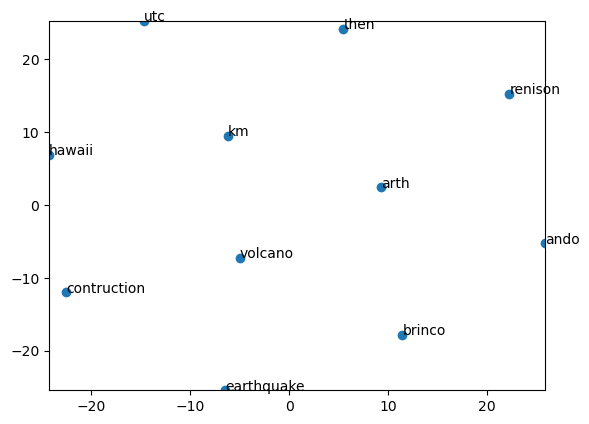

In [15]:
TSNE_10ClosestWords(cbow_model, 'earthquake', 1024)

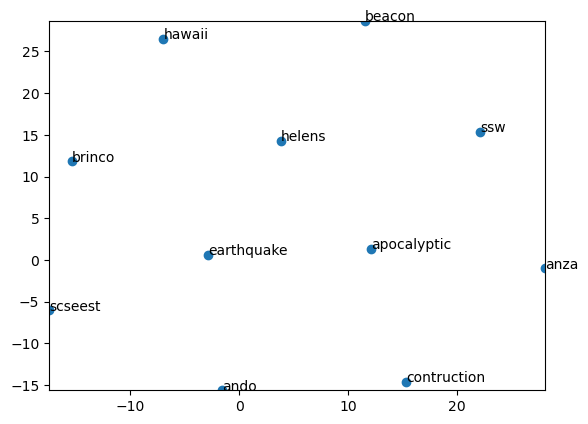

In [16]:
TSNE_10ClosestWords(skipgram_model, 'earthquake', 1024)

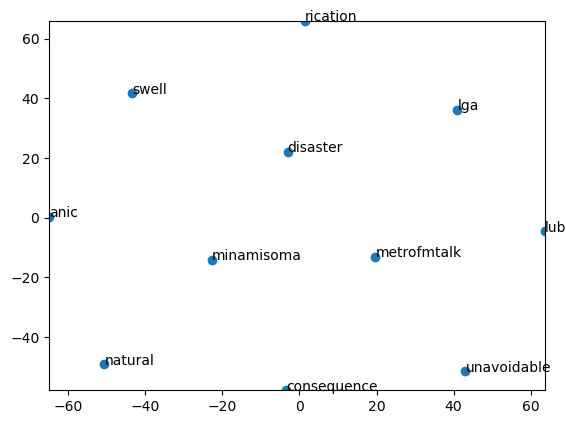

In [17]:
TSNE_10ClosestWords(cbow_model, 'disaster', 1024)

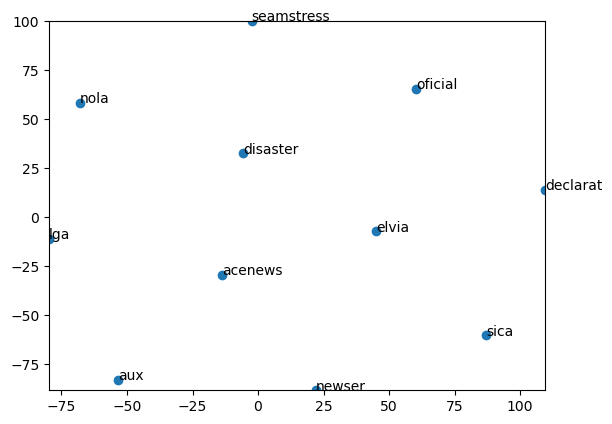

In [18]:
TSNE_10ClosestWords(skipgram_model, 'disaster', 1024)

# Loading and Testing our Pre-Trained Embeddings to the PyTorch's Embedding layer

In [19]:
# create embedding layer with pre-trained weights
pretrained_embeddings_layer = torch.nn.Embedding.from_pretrained(torch.FloatTensor(skipgram_model.wv.vectors))
# check weights of the pre-trained embedding layer
pretrained_embeddings_layer.weight

Parameter containing:
tensor([[-0.1576, -0.1942,  0.0403,  ...,  0.0539, -0.2986, -0.4338],
        [-0.4534, -0.5085,  0.0155,  ...,  0.1787,  0.2013, -0.9456],
        [-0.2642,  0.1099, -0.0788,  ...,  0.2809, -0.0191,  0.0766],
        ...,
        [ 0.1621,  0.1817,  0.1331,  ...,  0.1250, -0.1614, -0.0876],
        [-0.0478,  0.1445,  0.1973,  ...,  0.1166, -0.0971, -0.2256],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [20]:
TrainTweetsDataset = TweetsDataset(tweets_train, 'skipgram')
TrainTweetsDataset[0]

(tensor([ 4318,   430,   193,  1331,  2326, 13845, 13845, 13845, 13845, 13845,
         13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845,
         13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845,
         13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845,
         13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845, 13845]),
 tensor([1.]))

In [21]:
sequence = TrainTweetsDataset[0][0]
sequence_embeddings = pretrained_embeddings_layer(sequence)

print('Embedding of the first token:          {}'.format(sequence_embeddings[0]))
print('Embedding of the second token:         {}'.format(sequence_embeddings[1]))
print('Embedding of the third token:          {}'.format(sequence_embeddings[2]))
print('Embedding of the fourth token:         {}'.format(sequence_embeddings[3]))
print('Embedding of the fifth token:          {}'.format(sequence_embeddings[4]))
print('Embedding of the sixth token:          {}'.format(sequence_embeddings[5]))
print('Embedding of the twenty-fifth token:   {}'.format(sequence_embeddings[24]))
print('Embedding of the fortieth token:       {}'.format(sequence_embeddings[39]))
print('Embedding of the fiftieth token:       {}'.format(sequence_embeddings[48]))

Embedding of the first token:          tensor([ 1.4912e-01, -8.4140e-04,  2.2404e-01,  5.5450e-02,  8.9583e-02,
         2.1848e-01,  6.8861e-02, -2.4482e-01,  1.0519e-01, -2.1327e-01,
        -6.6395e-02, -1.2278e-01,  2.5271e-01, -1.2421e-01, -8.0806e-02,
         5.9938e-02,  2.1069e-01,  5.2437e-02, -2.9754e-01, -1.0679e-01,
         2.1623e-01,  4.4079e-03,  9.8411e-02, -2.5258e-01, -2.4562e-01,
        -1.0521e-01,  4.5064e-03, -1.2764e-01,  1.3645e-01,  5.8157e-02,
         5.0418e-02,  1.8263e-01,  6.1557e-02, -1.7144e-01, -2.7553e-02,
        -1.0233e-01, -8.1485e-02, -2.9838e-01, -3.3989e-01, -1.7210e-01,
        -1.3923e-01,  1.9787e-02, -5.6020e-02,  2.5737e-01,  1.1951e-02,
         9.7361e-02,  8.8058e-02, -1.9404e-01,  1.5763e-01,  3.5381e-02,
         1.5040e-01,  3.1605e-01, -4.8728e-02,  2.1368e-01, -3.1739e-01,
        -2.3778e-01,  1.2408e-01,  2.7924e-02,  5.3034e-02,  3.2247e-01,
         2.9198e-01,  2.7474e-03, -1.4979e-01,  1.4639e-01, -9.2595e-02,
        -1.4

# Training LSTM Neural Network with Custom Pre-trained Word2Vec Embeddings

## SkipGram embeddings

In [22]:
TrainTweetsDataset_SkipGram = TweetsDataset(tweets_train, 'skipgram')
# Create a dataloade for the training dataset
TrainDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_SkipGram, batch_size = 128, shuffle = True)

TestTweetsDataset_SkipGram = TweetsDataset(tweets_test, 'skipgram')
# Create a dataloade for the training dataset
TestDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TestTweetsDataset_SkipGram, batch_size = 128, shuffle = False)

In [23]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = skipgram_model,
                                  hidden_size = 64, 
                                  output_size = 1, 
                                  num_layers = 1, 
                                  bidirectional = True,
                                  freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 1e-4)

Device: mps


In [24]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loss = 0.6853 | Accuracy = 63.93% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:01<00:00, 39.06it/s]


Training Cross-Entropy Loss = 0.6916
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6931 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 76.46it/s]


Test Cross-Entropy Loss = 0.6894
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.6922 | Accuracy = 52.46% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:01<00:00, 48.11it/s]


Training Cross-Entropy Loss = 0.6875
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6947 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 75.46it/s]


Test Cross-Entropy Loss = 0.6857
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = 0.7058 | Accuracy = 47.54% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:01<00:00, 47.79it/s]


Training Cross-Entropy Loss = 0.6845
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6983 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 74.98it/s]


Test Cross-Entropy Loss = 0.6838
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = 0.6919 | Accuracy = 54.10% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:01<00:00, 48.21it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7017 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 78.10it/s]


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = 0.6643 | Accuracy = 63.93% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:01<00:00, 47.96it/s]


Training Cross-Entropy Loss = 0.6831
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7004 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 80.84it/s]


Test Cross-Entropy Loss = 0.6835
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = 0.6685 | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:01<00:00, 47.81it/s]


Training Cross-Entropy Loss = 0.6831
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7005 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 80.96it/s]


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = 0.6618 | Accuracy = 63.93% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:01<00:00, 48.20it/s]


Training Cross-Entropy Loss = 0.6831
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7018 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 78.68it/s]


Test Cross-Entropy Loss = 0.6835
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = 0.6757 | Accuracy = 59.02% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:01<00:00, 48.32it/s]


Training Cross-Entropy Loss = 0.6829
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6992 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 76.03it/s]

Test Cross-Entropy Loss = 0.6815
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [25]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = skipgram_model, 
                                                      hidden_size = 64, 
                                                      output_size = 1, 
                                                      num_layers = 1, 
                                                      bidirectional = True,
                                                      freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_Attention.parameters(), lr = 1e-4)

Device: mps


In [26]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM_Attention, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 16, device = device)

Epoch 1/16
======== Training phase ========


Loss = 0.6673 | Accuracy = 65.57% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.20it/s]


Training Cross-Entropy Loss = 0.6870
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6777 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 79.52it/s]


Test Cross-Entropy Loss = 0.6764
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/16
======== Training phase ========


Loss = 0.5784 | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.41it/s]


Training Cross-Entropy Loss = 0.6514
Training Accuracy = 57.13%
Training F1-Score = 0.43%
======== Validation phase ========


Loss = 0.5697 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 85.26it/s] 


Test Cross-Entropy Loss = 0.6082
Test Accuracy = 59.03%
Test F1-Score = 8.86%

Epoch 3/16
======== Training phase ========


Loss = 0.5131 | Accuracy = 78.69% | F1-Score = 60.61% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.73it/s]


Training Cross-Entropy Loss = 0.5243
Training Accuracy = 71.63%
Training F1-Score = 53.75%
======== Validation phase ========


Loss = 0.3850 | Accuracy = 84.13% | F1-Score = 80.77% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 82.24it/s]


Test Cross-Entropy Loss = 0.5217
Test Accuracy = 72.66%
Test F1-Score = 55.97%

Epoch 4/16
======== Training phase ========


Loss = 0.4704 | Accuracy = 78.69% | F1-Score = 76.36% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.60it/s]


Training Cross-Entropy Loss = 0.4501
Training Accuracy = 79.55%
Training F1-Score = 71.96%
======== Validation phase ========


Loss = 0.3446 | Accuracy = 88.89% | F1-Score = 87.27% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 82.99it/s]


Test Cross-Entropy Loss = 0.4926
Test Accuracy = 76.62%
Test F1-Score = 65.77%

Epoch 5/16
======== Training phase ========


Loss = 0.3825 | Accuracy = 81.97% | F1-Score = 71.79% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.52it/s]


Training Cross-Entropy Loss = 0.4204
Training Accuracy = 81.22%
Training F1-Score = 74.86%
======== Validation phase ========


Loss = 0.3501 | Accuracy = 88.89% | F1-Score = 87.27% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 88.98it/s]


Test Cross-Entropy Loss = 0.5035
Test Accuracy = 75.76%
Test F1-Score = 63.02%

Epoch 6/16
======== Training phase ========


Loss = 0.4371 | Accuracy = 81.97% | F1-Score = 73.17% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.53it/s]


Training Cross-Entropy Loss = 0.3984
Training Accuracy = 82.37%
Training F1-Score = 76.64%
======== Validation phase ========


Loss = 0.3450 | Accuracy = 88.89% | F1-Score = 87.27% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 84.92it/s]


Test Cross-Entropy Loss = 0.4931
Test Accuracy = 76.77%
Test F1-Score = 65.58%

Epoch 7/16
======== Training phase ========


Loss = 0.4116 | Accuracy = 81.97% | F1-Score = 78.43% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.52it/s]


Training Cross-Entropy Loss = 0.3783
Training Accuracy = 83.34%
Training F1-Score = 78.09%
======== Validation phase ========


Loss = 0.3467 | Accuracy = 90.48% | F1-Score = 89.29% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 88.22it/s]


Test Cross-Entropy Loss = 0.4946
Test Accuracy = 77.35%
Test F1-Score = 66.70%

Epoch 8/16
======== Training phase ========


Loss = 0.3236 | Accuracy = 85.25% | F1-Score = 76.92% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.49it/s]


Training Cross-Entropy Loss = 0.3569
Training Accuracy = 84.22%
Training F1-Score = 79.34%
======== Validation phase ========


Loss = 0.3654 | Accuracy = 90.48% | F1-Score = 89.29% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 88.04it/s] 


Test Cross-Entropy Loss = 0.5237
Test Accuracy = 76.16%
Test F1-Score = 63.75%

Epoch 9/16
======== Training phase ========


Loss = 0.3137 | Accuracy = 88.52% | F1-Score = 84.44% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.43it/s]


Training Cross-Entropy Loss = 0.3363
Training Accuracy = 85.37%
Training F1-Score = 81.05%
======== Validation phase ========


Loss = 0.3753 | Accuracy = 90.48% | F1-Score = 89.29% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 87.75it/s]


Test Cross-Entropy Loss = 0.5366
Test Accuracy = 76.10%
Test F1-Score = 63.69%

Epoch 10/16
======== Training phase ========


Loss = 0.2085 | Accuracy = 91.80% | F1-Score = 90.20% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.54it/s]


Training Cross-Entropy Loss = 0.3126
Training Accuracy = 86.25%
Training F1-Score = 82.30%
======== Validation phase ========


Loss = 0.3880 | Accuracy = 88.89% | F1-Score = 87.72% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 86.06it/s]


Test Cross-Entropy Loss = 0.5473
Test Accuracy = 76.40%
Test F1-Score = 64.52%

Epoch 11/16
======== Training phase ========


Loss = 0.3319 | Accuracy = 86.89% | F1-Score = 80.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.48it/s]


Training Cross-Entropy Loss = 0.2898
Training Accuracy = 87.39%
Training F1-Score = 83.84%
======== Validation phase ========


Loss = 0.3936 | Accuracy = 88.89% | F1-Score = 87.72% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 84.00it/s]


Test Cross-Entropy Loss = 0.5597
Test Accuracy = 76.65%
Test F1-Score = 65.40%

Epoch 12/16
======== Training phase ========


Loss = 0.2262 | Accuracy = 95.08% | F1-Score = 92.68% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.82it/s]


Training Cross-Entropy Loss = 0.2613
Training Accuracy = 88.53%
Training F1-Score = 85.50%
======== Validation phase ========


Loss = 0.4229 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 81.51it/s]


Test Cross-Entropy Loss = 0.5961
Test Accuracy = 76.13%
Test F1-Score = 64.48%

Epoch 13/16
======== Training phase ========


Loss = 0.2497 | Accuracy = 91.80% | F1-Score = 87.80% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.51it/s]


Training Cross-Entropy Loss = 0.2352
Training Accuracy = 90.08%
Training F1-Score = 87.56%
======== Validation phase ========


Loss = 0.4288 | Accuracy = 85.71% | F1-Score = 84.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 83.63it/s]


Test Cross-Entropy Loss = 0.6194
Test Accuracy = 76.37%
Test F1-Score = 65.38%

Epoch 14/16
======== Training phase ========


Loss = 0.1969 | Accuracy = 93.44% | F1-Score = 87.50% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.29it/s]


Training Cross-Entropy Loss = 0.2059
Training Accuracy = 91.63%
Training F1-Score = 89.63%
======== Validation phase ========


Loss = 0.4120 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 80.88it/s]


Test Cross-Entropy Loss = 0.6330
Test Accuracy = 77.29%
Test F1-Score = 67.99%

Epoch 15/16
======== Training phase ========


Loss = 0.1946 | Accuracy = 90.16% | F1-Score = 86.96% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.44it/s]


Training Cross-Entropy Loss = 0.1834
Training Accuracy = 92.60%
Training F1-Score = 90.94%
======== Validation phase ========


Loss = 0.4362 | Accuracy = 85.71% | F1-Score = 84.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 86.14it/s]


Test Cross-Entropy Loss = 0.6831
Test Accuracy = 76.89%
Test F1-Score = 66.81%

Epoch 16/16
======== Training phase ========


Loss = 0.1074 | Accuracy = 95.08% | F1-Score = 92.68% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 17.51it/s]


Training Cross-Entropy Loss = 0.1600
Training Accuracy = 93.77%
Training F1-Score = 92.44%
======== Validation phase ========


Loss = 0.4255 | Accuracy = 85.71% | F1-Score = 84.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 81.33it/s]

Test Cross-Entropy Loss = 0.7076
Test Accuracy = 76.65%
Test F1-Score = 67.21%



In [28]:
# Initialize the network, loss function, and optimizer
device = set_device()

customPreTrainedLSTM_MultiheadAttention = CustomLSTM_MultiHeadAttention(word2vec_model = skipgram_model,
                                                                        hidden_size = 1024, 
                                                                        output_size = 1, 
                                                                        dropout = 0.1,
                                                                        num_layers = 1, 
                                                                        bidirectional = True,
                                                                        freeze_embeddings = True,
                                                                        num_heads = 16).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_MultiheadAttention.parameters(), lr = 1e-5)

Device: mps


In [29]:
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedLSTM_MultiheadAttention, 
                                                       train_loader = TrainDataLoader_SkipGram, 
                                                       test_loader = TestDataLoader_SkipGram, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 16, 
                                                       device = device)

Epoch 1/16
======== Training phase ========


Loss = 0.5430 | Accuracy = 73.77% | F1-Score = 69.23% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.82it/s]


Training Cross-Entropy Loss = 0.6806
Training Accuracy = 73.81%
Training F1-Score = 67.88%
======== Validation phase ========


Loss = 0.4502 | Accuracy = 82.54% | F1-Score = 83.08% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.23it/s]


Test Cross-Entropy Loss = 0.6062
Test Accuracy = 73.00%
Test F1-Score = 70.17%

Epoch 2/16
======== Training phase ========


Loss = 0.5971 | Accuracy = 78.69% | F1-Score = 69.77% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.86it/s]


Training Cross-Entropy Loss = 0.4918
Training Accuracy = 79.08%
Training F1-Score = 73.53%
======== Validation phase ========


Loss = 0.4347 | Accuracy = 80.95% | F1-Score = 79.31% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.12it/s]


Test Cross-Entropy Loss = 0.5471
Test Accuracy = 75.79%
Test F1-Score = 69.59%

Epoch 3/16
======== Training phase ========


Loss = 0.7244 | Accuracy = 65.57% | F1-Score = 51.16% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.82it/s]


Training Cross-Entropy Loss = 0.4611
Training Accuracy = 80.07%
Training F1-Score = 74.65%
======== Validation phase ========


Loss = 0.6896 | Accuracy = 76.19% | F1-Score = 68.09% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.21it/s]


Test Cross-Entropy Loss = 0.9887
Test Accuracy = 67.97%
Test F1-Score = 41.59%

Epoch 4/16
======== Training phase ========


Loss = 0.4442 | Accuracy = 83.61% | F1-Score = 77.27% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.4223
Training Accuracy = 81.69%
Training F1-Score = 76.59%
======== Validation phase ========


Loss = 0.5707 | Accuracy = 76.19% | F1-Score = 78.26% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.21it/s]


Test Cross-Entropy Loss = 0.6778
Test Accuracy = 71.01%
Test F1-Score = 70.01%

Epoch 5/16
======== Training phase ========


Loss = 0.3106 | Accuracy = 90.16% | F1-Score = 86.36% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


Training Cross-Entropy Loss = 0.3773
Training Accuracy = 83.62%
Training F1-Score = 78.98%
======== Validation phase ========


Loss = 0.3773 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.27it/s]


Test Cross-Entropy Loss = 0.5410
Test Accuracy = 76.62%
Test F1-Score = 69.05%

Epoch 6/16
======== Training phase ========


Loss = 0.5707 | Accuracy = 72.13% | F1-Score = 70.18% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.3567
Training Accuracy = 84.36%
Training F1-Score = 79.76%
======== Validation phase ========


Loss = 0.3735 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.24it/s]


Test Cross-Entropy Loss = 0.5663
Test Accuracy = 75.54%
Test F1-Score = 71.74%

Epoch 7/16
======== Training phase ========


Loss = 0.4005 | Accuracy = 85.25% | F1-Score = 83.64% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


Training Cross-Entropy Loss = 0.3284
Training Accuracy = 86.33%
Training F1-Score = 82.61%
======== Validation phase ========


Loss = 0.3234 | Accuracy = 92.06% | F1-Score = 91.53% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.21it/s]


Test Cross-Entropy Loss = 0.5283
Test Accuracy = 76.43%
Test F1-Score = 71.12%

Epoch 8/16
======== Training phase ========


Loss = 0.2410 | Accuracy = 93.44% | F1-Score = 90.48% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.2975
Training Accuracy = 87.56%
Training F1-Score = 84.24%
======== Validation phase ========


Loss = 0.3618 | Accuracy = 87.30% | F1-Score = 85.19% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.26it/s]


Test Cross-Entropy Loss = 0.5363
Test Accuracy = 76.59%
Test F1-Score = 66.43%

Epoch 9/16
======== Training phase ========


Loss = 0.4415 | Accuracy = 81.97% | F1-Score = 78.43% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.2801
Training Accuracy = 87.88%
Training F1-Score = 84.71%
======== Validation phase ========


Loss = 0.3843 | Accuracy = 88.89% | F1-Score = 88.52% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.29it/s]


Test Cross-Entropy Loss = 0.5959
Test Accuracy = 73.34%
Test F1-Score = 69.43%

Epoch 10/16
======== Training phase ========


Loss = 0.3002 | Accuracy = 81.97% | F1-Score = 78.43% | Batch ID = 60 : 100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


Training Cross-Entropy Loss = 0.2630
Training Accuracy = 89.37%
Training F1-Score = 86.71%
======== Validation phase ========


Loss = 0.3629 | Accuracy = 84.13% | F1-Score = 80.77% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.20it/s]


Test Cross-Entropy Loss = 0.5388
Test Accuracy = 75.91%
Test F1-Score = 65.19%

Epoch 11/16
======== Training phase ========


Loss = 0.2693 | Accuracy = 86.89% | F1-Score = 85.71% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


Training Cross-Entropy Loss = 0.2424
Training Accuracy = 90.32%
Training F1-Score = 87.98%
======== Validation phase ========


Loss = 0.4242 | Accuracy = 87.30% | F1-Score = 87.50% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.29it/s]


Test Cross-Entropy Loss = 0.5739
Test Accuracy = 75.27%
Test F1-Score = 71.04%

Epoch 12/16
======== Training phase ========


Loss = 0.2492 | Accuracy = 90.16% | F1-Score = 88.89% | Batch ID = 60 : 100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


Training Cross-Entropy Loss = 0.2325
Training Accuracy = 90.71%
Training F1-Score = 88.52%
======== Validation phase ========


Loss = 0.3658 | Accuracy = 85.71% | F1-Score = 83.02% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.31it/s]


Test Cross-Entropy Loss = 0.5546
Test Accuracy = 76.89%
Test F1-Score = 66.81%

Epoch 13/16
======== Training phase ========


Loss = 0.2020 | Accuracy = 93.44% | F1-Score = 92.31% | Batch ID = 60 : 100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


Training Cross-Entropy Loss = 0.2122
Training Accuracy = 91.57%
Training F1-Score = 89.59%
======== Validation phase ========


Loss = 0.4331 | Accuracy = 87.30% | F1-Score = 87.50% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.26it/s]


Test Cross-Entropy Loss = 0.6075
Test Accuracy = 74.16%
Test F1-Score = 71.18%

Epoch 14/16
======== Training phase ========


Loss = 0.3414 | Accuracy = 86.89% | F1-Score = 87.10% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.1955
Training Accuracy = 92.74%
Training F1-Score = 91.07%
======== Validation phase ========


Loss = 0.4181 | Accuracy = 84.13% | F1-Score = 81.48% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.26it/s]


Test Cross-Entropy Loss = 0.6484
Test Accuracy = 74.47%
Test F1-Score = 59.97%

Epoch 15/16
======== Training phase ========


Loss = 0.2540 | Accuracy = 88.52% | F1-Score = 86.79% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.1948
Training Accuracy = 92.68%
Training F1-Score = 91.09%
======== Validation phase ========


Loss = 0.3523 | Accuracy = 87.30% | F1-Score = 85.71% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.25it/s]


Test Cross-Entropy Loss = 0.5383
Test Accuracy = 77.44%
Test F1-Score = 67.69%

Epoch 16/16
======== Training phase ========


Loss = 0.2501 | Accuracy = 91.80% | F1-Score = 88.89% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.1737
Training Accuracy = 93.87%
Training F1-Score = 92.58%
======== Validation phase ========


Loss = 0.3687 | Accuracy = 87.30% | F1-Score = 87.10% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.22it/s]

Test Cross-Entropy Loss = 0.5755
Test Accuracy = 76.06%
Test F1-Score = 71.65%



## CBOW embeddings

In [19]:
TrainTweetsDataset_CBOW = TweetsDataset(tweets_train, 'cbow')
# Create a dataloade for the training dataset
TrainDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_CBOW, batch_size = 32, shuffle = True)

TestTweetsDataset_CBOW = TweetsDataset(tweets_test, 'cbow')
# Create a dataloade for the training dataset
TestDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TestTweetsDataset_CBOW, batch_size = 32, shuffle = False)

In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = cbow_model,
                                  hidden_size = 256, 
                                  output_size = 1, 
                                  num_layers = 3, 
                                  bidirectional = True,
                                  freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6825 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 15.10it/s]


Training Cross-Entropy Loss = 0.6866
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6992 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 39.84it/s]


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.7362 | Accuracy = 37.70% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.18it/s]


Training Cross-Entropy Loss = 0.6843
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7003 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 42.05it/s]


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = 0.6908 | Accuracy = 54.10% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.44it/s]


Training Cross-Entropy Loss = 0.6835
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6990 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 40.79it/s]


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = 0.6981 | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.36it/s]


Training Cross-Entropy Loss = 0.6835
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6979 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.65it/s]


Test Cross-Entropy Loss = 0.6839
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = 0.6955 | Accuracy = 52.46% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.43it/s]


Training Cross-Entropy Loss = 0.6837
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6997 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 40.48it/s]


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = 0.6823 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.17it/s]


Training Cross-Entropy Loss = 0.6835
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7009 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 42.01it/s]


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = 0.6866 | Accuracy = 55.74% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.42it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6975 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.00it/s]


Test Cross-Entropy Loss = 0.6840
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = 0.6826 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.44it/s]


Training Cross-Entropy Loss = 0.6835
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6985 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.84it/s]

Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [25]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = cbow_model, 
                                                      hidden_size = 512, 
                                                      output_size = 1, 
                                                      num_layers = 1, 
                                                      bidirectional = True,
                                                      freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(customPreTrainedLSTM_Attention.parameters(), lr = 1e-5)

Device: mps


In [26]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM_Attention, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 16, device = device)

Epoch 1/16
======== Training phase ========


Loss = 0.6526 | Accuracy = 51.72% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.79it/s] 


Training Cross-Entropy Loss = 0.6709
Training Accuracy = 57.15%
Training F1-Score = 0.55%
======== Validation phase ========


Loss = 0.6085 | Accuracy = 32.26% | F1-Score = 8.70% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 73.42it/s] 


Test Cross-Entropy Loss = 0.6354
Test Accuracy = 58.54%
Test F1-Score = 6.75%

Epoch 2/16
======== Training phase ========


Loss = 0.3897 | Accuracy = 89.66% | F1-Score = 82.35% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.91it/s]


Training Cross-Entropy Loss = 0.5281
Training Accuracy = 71.21%
Training F1-Score = 53.48%
======== Validation phase ========


Loss = 0.3595 | Accuracy = 80.65% | F1-Score = 84.21% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 73.20it/s]


Test Cross-Entropy Loss = 0.4843
Test Accuracy = 75.85%
Test F1-Score = 64.76%

Epoch 3/16
======== Training phase ========


Loss = 0.3956 | Accuracy = 75.86% | F1-Score = 69.57% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.85it/s]


Training Cross-Entropy Loss = 0.4647
Training Accuracy = 77.55%
Training F1-Score = 69.00%
======== Validation phase ========


Loss = 0.3565 | Accuracy = 80.65% | F1-Score = 84.21% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 72.37it/s]


Test Cross-Entropy Loss = 0.4744
Test Accuracy = 76.89%
Test F1-Score = 66.78%

Epoch 4/16
======== Training phase ========


Loss = 0.4816 | Accuracy = 75.86% | F1-Score = 58.82% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.84it/s]


Training Cross-Entropy Loss = 0.4517
Training Accuracy = 78.30%
Training F1-Score = 70.43%
======== Validation phase ========


Loss = 0.3636 | Accuracy = 80.65% | F1-Score = 84.21% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 70.32it/s]


Test Cross-Entropy Loss = 0.4717
Test Accuracy = 76.92%
Test F1-Score = 66.58%

Epoch 5/16
======== Training phase ========


Loss = 0.4523 | Accuracy = 72.41% | F1-Score = 63.64% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.89it/s]


Training Cross-Entropy Loss = 0.4424
Training Accuracy = 78.75%
Training F1-Score = 71.03%
======== Validation phase ========


Loss = 0.3546 | Accuracy = 80.65% | F1-Score = 85.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 71.65it/s]


Test Cross-Entropy Loss = 0.4669
Test Accuracy = 77.23%
Test F1-Score = 67.71%

Epoch 6/16
======== Training phase ========


Loss = 0.4181 | Accuracy = 86.21% | F1-Score = 75.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.87it/s]


Training Cross-Entropy Loss = 0.4344
Training Accuracy = 79.54%
Training F1-Score = 72.68%
======== Validation phase ========


Loss = 0.3607 | Accuracy = 80.65% | F1-Score = 85.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 71.79it/s]


Test Cross-Entropy Loss = 0.4671
Test Accuracy = 77.05%
Test F1-Score = 66.99%

Epoch 7/16
======== Training phase ========


Loss = 0.4042 | Accuracy = 79.31% | F1-Score = 66.67% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.86it/s]


Training Cross-Entropy Loss = 0.4266
Training Accuracy = 79.92%
Training F1-Score = 73.09%
======== Validation phase ========


Loss = 0.3511 | Accuracy = 80.65% | F1-Score = 85.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 72.73it/s]


Test Cross-Entropy Loss = 0.4629
Test Accuracy = 77.97%
Test F1-Score = 69.34%

Epoch 8/16
======== Training phase ========


Loss = 0.3657 | Accuracy = 79.31% | F1-Score = 66.67% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.99it/s]


Training Cross-Entropy Loss = 0.4192
Training Accuracy = 80.48%
Training F1-Score = 74.12%
======== Validation phase ========


Loss = 0.3562 | Accuracy = 80.65% | F1-Score = 85.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 73.85it/s]


Test Cross-Entropy Loss = 0.4639
Test Accuracy = 78.12%
Test F1-Score = 69.62%

Epoch 9/16
======== Training phase ========


Loss = 0.2081 | Accuracy = 96.55% | F1-Score = 93.33% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 23.06it/s]


Training Cross-Entropy Loss = 0.4119
Training Accuracy = 80.99%
Training F1-Score = 74.86%
======== Validation phase ========


Loss = 0.3466 | Accuracy = 80.65% | F1-Score = 85.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 74.51it/s]


Test Cross-Entropy Loss = 0.4611
Test Accuracy = 78.58%
Test F1-Score = 70.96%

Epoch 10/16
======== Training phase ========


Loss = 0.4598 | Accuracy = 79.31% | F1-Score = 76.92% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.98it/s]


Training Cross-Entropy Loss = 0.4038
Training Accuracy = 81.19%
Training F1-Score = 75.34%
======== Validation phase ========


Loss = 0.3460 | Accuracy = 83.87% | F1-Score = 87.80% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 72.26it/s]


Test Cross-Entropy Loss = 0.4608
Test Accuracy = 78.33%
Test F1-Score = 70.60%

Epoch 11/16
======== Training phase ========


Loss = 0.3098 | Accuracy = 89.66% | F1-Score = 72.73% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.95it/s]


Training Cross-Entropy Loss = 0.3962
Training Accuracy = 81.89%
Training F1-Score = 76.60%
======== Validation phase ========


Loss = 0.3582 | Accuracy = 83.87% | F1-Score = 87.80% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 69.45it/s]


Test Cross-Entropy Loss = 0.4651
Test Accuracy = 78.55%
Test F1-Score = 70.46%

Epoch 12/16
======== Training phase ========


Loss = 0.3294 | Accuracy = 82.76% | F1-Score = 78.26% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.76it/s]


Training Cross-Entropy Loss = 0.3881
Training Accuracy = 82.56%
Training F1-Score = 77.48%
======== Validation phase ========


Loss = 0.3580 | Accuracy = 83.87% | F1-Score = 87.80% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 69.75it/s]


Test Cross-Entropy Loss = 0.4657
Test Accuracy = 78.39%
Test F1-Score = 70.24%

Epoch 13/16
======== Training phase ========


Loss = 0.6655 | Accuracy = 75.86% | F1-Score = 63.16% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.81it/s]


Training Cross-Entropy Loss = 0.3800
Training Accuracy = 83.12%
Training F1-Score = 78.33%
======== Validation phase ========


Loss = 0.3481 | Accuracy = 83.87% | F1-Score = 87.80% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 68.61it/s]


Test Cross-Entropy Loss = 0.4674
Test Accuracy = 78.88%
Test F1-Score = 71.68%

Epoch 14/16
======== Training phase ========


Loss = 0.2849 | Accuracy = 86.21% | F1-Score = 83.33% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.91it/s]


Training Cross-Entropy Loss = 0.3715
Training Accuracy = 83.50%
Training F1-Score = 78.99%
======== Validation phase ========


Loss = 0.3642 | Accuracy = 83.87% | F1-Score = 87.80% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 71.61it/s]


Test Cross-Entropy Loss = 0.4726
Test Accuracy = 78.33%
Test F1-Score = 70.36%

Epoch 15/16
======== Training phase ========


Loss = 0.2378 | Accuracy = 86.21% | F1-Score = 86.67% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 22.88it/s]  


Training Cross-Entropy Loss = 0.3627
Training Accuracy = 84.43%
Training F1-Score = 80.36%
======== Validation phase ========


Loss = 0.3625 | Accuracy = 83.87% | F1-Score = 87.80% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 74.22it/s]


Test Cross-Entropy Loss = 0.4699
Test Accuracy = 78.76%
Test F1-Score = 71.79%

Epoch 16/16
======== Training phase ========


Loss = 0.3020 | Accuracy = 89.66% | F1-Score = 85.71% | Batch ID = 238 : 100%|██████████| 238/238 [00:10<00:00, 23.01it/s]


Training Cross-Entropy Loss = 0.3531
Training Accuracy = 84.83%
Training F1-Score = 80.94%
======== Validation phase ========


Loss = 0.3612 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:01<00:00, 73.77it/s]

Test Cross-Entropy Loss = 0.4789
Test Accuracy = 78.64%
Test F1-Score = 72.83%



# Training GRU Neural Network with Custom Pre-trained Word2Vec Embeddings

## SkipGram Embeddings

In [ ]:
TrainTweetsDataset_SkipGram = TweetsDataset(tweets_train, 'skipgram')
# Create a dataloade for the training dataset
TrainDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_SkipGram, batch_size = 128, shuffle = True)

TestTweetsDataset_SkipGram = TweetsDataset(tweets_test, 'skipgram')
# Create a dataloade for the training dataset
TestDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TestTweetsDataset_SkipGram, batch_size = 128, shuffle = False)

In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU = CustomGRU(word2vec_model = skipgram_model, 
                                hidden_size = 256, 
                                output_size = 1, 
                                num_layers = 3, 
                                bidirectional = True,
                                freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6691 | Accuracy = 60.66% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:39<00:00,  1.53it/s]


Training Cross-Entropy Loss = 0.6842
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7072 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:05<00:00,  4.47it/s]


Test Cross-Entropy Loss = 0.6841
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.7125 | Accuracy = 47.54% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:38<00:00,  1.55it/s]


Training Cross-Entropy Loss = 0.6837
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7051 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:05<00:00,  4.48it/s]


Test Cross-Entropy Loss = 0.6839
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = 0.6834 | Accuracy = 57.03% | F1-Score = 0.00% | Batch ID = 2 :   3%|▎         | 2/60 [00:01<00:56,  1.03it/s]


KeyboardInterrupt: 

In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU_Attention = CustomGRU_Attention(word2vec_model = skipgram_model, 
                                                    hidden_size = 256, 
                                                    output_size = 1, 
                                                    num_layers = 3, 
                                                    bidirectional = True,
                                                    freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU_Attention.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU_Attention, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.5972 | Accuracy = 66.14% | F1-Score = 39.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


Training Cross-Entropy Loss = 0.6553
Training Accuracy = 58.26%
Training F1-Score = 5.59%
======== Validation phase ========


Loss = 0.5561 | Accuracy = 67.54% | F1-Score = 56.34% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.99it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 65.22%
Test F1-Score = 33.97%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 55.03% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.61it/s]  


Training Cross-Entropy Loss = nan
Training Accuracy = 58.30%
Training F1-Score = 5.81%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.92it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 54.50% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.46it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 52.91% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.59it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.95it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 59.26% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.61it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.97it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 47.62% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.44it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.64it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 60.85% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.71it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 54.50% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.90it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



## CBOW Embeddings

In [ ]:
TrainTweetsDataset_CBOW = TweetsDataset(tweets_train, 'cbow')
# Create a dataloade for the training dataset
TrainDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_CBOW, batch_size = 128, shuffle = True)

TestTweetsDataset_CBOW = TweetsDataset(tweets_test, 'cbow')
# Create a dataloade for the training dataset
TestDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TestTweetsDataset_CBOW, batch_size = 128, shuffle = False)

In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU = CustomGRU(word2vec_model = cbow_model, 
                                hidden_size = 256, 
                                output_size = 1, 
                                num_layers = 3, 
                                bidirectional = True,
                                freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = nan | Accuracy = 57.67% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.44it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 59.79% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.88it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 56.61% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.41it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 63.49% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.14it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 60.32% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.34it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 61.90% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.67it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.99it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 59.26% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.67it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.25it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 55.56% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.46it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.74it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU_Attention = CustomGRU_Attention(word2vec_model = cbow_model, 
                                                    hidden_size = 256, 
                                                    output_size = 1, 
                                                    num_layers = 3, 
                                                    bidirectional = True,
                                                    freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU_Attention.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU_Attention, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = nan | Accuracy = 58.20% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.99it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 58.73% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.91it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 52.91% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.45it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 52.38% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.08it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 55.56% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.93it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 62.96% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.53it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 59.79% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.63it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 56.61% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.34it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



# DistilBERT

In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the DistilBERT tokenizer and model for sequence classification
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

In [7]:
# Tokenize training data
train_encodings = tokenizer(tweets_train['clean_text'].tolist(), truncation=True, padding=True, return_tensors="pt")

In [8]:
# Convert labels to PyTorch tensors
train_labels = torch.tensor(tweets_train['target'].tolist())

In [9]:
# Create a DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [120]:
# Load a model savel with extentions .bin
model = DistilBertForSequenceClassification.from_pretrained(model_name)
# Adjust DistilBERT for binary classification
model.classifier = torch.nn.Linear(768, 1)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

In [11]:
# Tokenize test data
test_encodings = tokenizer(tweets_test['clean_text'].tolist(), truncation=True, padding=True, return_tensors="pt")
# Convert labels to PyTorch tensors
test_labels = torch.tensor(tweets_test['target'].tolist())
# Create a DataLoader for training data
test_dataset = torch.utils.data.TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [121]:
# Initialize the network, loss function, and optimizer
device = set_device()
DistilBERT = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(DistilBERT.parameters(), lr = 1e-5, weight_decay = 1e-3)

Device: mps


In [122]:
train_losses, train_f1s, test_losses, test_f1s = train_BERT(DistilBERT, train_loader, test_loader, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.2964 | Accuracy = 89.66% | F1-Score = 89.66% | Batch ID = 238 : 100%|██████████| 238/238 [00:24<00:00,  9.86it/s]  


Training Cross-Entropy Loss = 0.4925
Training Accuracy = 77.59%
Training F1-Score = 70.15%
======== Validation phase ========


Loss = 0.3072 | Accuracy = 90.32% | F1-Score = 89.66% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 32.66it/s]


Test Cross-Entropy Loss = 0.4437
Test Accuracy = 80.45%
Test F1-Score = 76.95%

Epoch 2/8
======== Training phase ========


Loss = 0.4128 | Accuracy = 86.21% | F1-Score = 83.33% | Batch ID = 238 : 100%|██████████| 238/238 [00:24<00:00,  9.89it/s]  


Training Cross-Entropy Loss = 0.3879
Training Accuracy = 83.86%
Training F1-Score = 79.87%
======== Validation phase ========


Loss = 0.3541 | Accuracy = 87.10% | F1-Score = 83.33% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 32.71it/s]


Test Cross-Entropy Loss = 0.4110
Test Accuracy = 82.26%
Test F1-Score = 77.32%

Epoch 3/8
======== Training phase ========


Loss = 0.2588 | Accuracy = 89.66% | F1-Score = 89.66% | Batch ID = 238 : 100%|██████████| 238/238 [00:24<00:00,  9.90it/s]  


Training Cross-Entropy Loss = 0.3409
Training Accuracy = 86.89%
Training F1-Score = 83.76%
======== Validation phase ========


Loss = 0.4910 | Accuracy = 77.42% | F1-Score = 69.57% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 32.54it/s]


Test Cross-Entropy Loss = 0.4258
Test Accuracy = 81.98%
Test F1-Score = 77.52%

Epoch 4/8
======== Training phase ========


Loss = 0.4039 | Accuracy = 86.21% | F1-Score = 86.67% | Batch ID = 238 : 100%|██████████| 238/238 [00:24<00:00,  9.91it/s]  


Training Cross-Entropy Loss = 0.2964
Training Accuracy = 88.91%
Training F1-Score = 86.26%
======== Validation phase ========


Loss = 0.5968 | Accuracy = 74.19% | F1-Score = 77.78% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 32.63it/s]


Test Cross-Entropy Loss = 0.4529
Test Accuracy = 80.82%
Test F1-Score = 77.37%

Epoch 5/8
======== Training phase ========


Loss = 0.4699 | Accuracy = 79.31% | F1-Score = 75.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:24<00:00,  9.69it/s]  


Training Cross-Entropy Loss = 0.2557
Training Accuracy = 90.75%
Training F1-Score = 88.69%
======== Validation phase ========


Loss = 0.4525 | Accuracy = 83.87% | F1-Score = 76.19% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 32.52it/s]


Test Cross-Entropy Loss = 0.4692
Test Accuracy = 82.07%
Test F1-Score = 77.85%

Epoch 6/8
======== Training phase ========


Loss = 0.1161 | Accuracy = 96.55% | F1-Score = 95.24% | Batch ID = 238 : 100%|██████████| 238/238 [00:24<00:00,  9.58it/s]  


Training Cross-Entropy Loss = 0.2166
Training Accuracy = 92.18%
Training F1-Score = 90.48%
======== Validation phase ========


Loss = 0.5097 | Accuracy = 80.65% | F1-Score = 76.92% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 31.91it/s]


Test Cross-Entropy Loss = 0.4992
Test Accuracy = 81.55%
Test F1-Score = 77.28%

Epoch 7/8
======== Training phase ========


Loss = 0.2562 | Accuracy = 89.66% | F1-Score = 84.21% | Batch ID = 238 : 100%|██████████| 238/238 [00:24<00:00,  9.54it/s]  


Training Cross-Entropy Loss = 0.1879
Training Accuracy = 93.38%
Training F1-Score = 91.99%
======== Validation phase ========


Loss = 0.5145 | Accuracy = 77.42% | F1-Score = 72.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 31.89it/s]


Test Cross-Entropy Loss = 0.5088
Test Accuracy = 81.73%
Test F1-Score = 77.56%

Epoch 8/8
======== Training phase ========


Loss = 0.2789 | Accuracy = 89.66% | F1-Score = 85.71% | Batch ID = 238 : 100%|██████████| 238/238 [00:24<00:00,  9.63it/s]  


Training Cross-Entropy Loss = 0.1608
Training Accuracy = 94.50%
Training F1-Score = 93.38%
======== Validation phase ========


Loss = 0.5422 | Accuracy = 83.87% | F1-Score = 76.19% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 31.89it/s]

Test Cross-Entropy Loss = 0.5399
Test Accuracy = 81.46%
Test F1-Score = 77.94%



# BERT

In [123]:
from transformers import BertTokenizer, BertForSequenceClassification

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [124]:
# Tokenize training data
train_encodings = tokenizer(tweets_train['clean_text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Convert labels to PyTorch tensors
train_labels = torch.tensor(tweets_train['target'].tolist())

# Create a DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


# Tokenize test data
test_encodings = tokenizer(tweets_test['clean_text'].tolist(), truncation=True, padding=True, return_tensors="pt")
# Convert labels to PyTorch tensors
test_labels = torch.tensor(tweets_test['target'].tolist())
# Create a DataLoader for training data
test_dataset = torch.utils.data.TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [131]:
# Load the BERT model for sequence classification
bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
# Adjust DistilBERT for binary classification
# bert.classifier = torch.nn.Linear(768, 1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [133]:
# Initialize the network, loss function, and optimizer
device = set_device()
bert = bert.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(bert.parameters(), lr = 1e-5, weight_decay = 1e-3)

Device: mps


In [134]:
train_losses, train_f1s, test_losses, test_f1s = train_BERT(bert, train_loader, test_loader, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.5043 | Accuracy = 79.31% | F1-Score = 84.21% | Batch ID = 238 : 100%|██████████| 238/238 [00:50<00:00,  4.72it/s]


Training Cross-Entropy Loss = 0.4867
Training Accuracy = 78.23%
Training F1-Score = 72.31%
======== Validation phase ========


Loss = 0.5482 | Accuracy = 70.97% | F1-Score = 66.67% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 19.33it/s]


Test Cross-Entropy Loss = 0.4430
Test Accuracy = 80.57%
Test F1-Score = 77.88%

Epoch 2/8
======== Training phase ========


Loss = 0.5764 | Accuracy = 79.31% | F1-Score = 80.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:49<00:00,  4.77it/s]  


Training Cross-Entropy Loss = 0.3802
Training Accuracy = 84.55%
Training F1-Score = 80.87%
======== Validation phase ========


Loss = 0.4920 | Accuracy = 74.19% | F1-Score = 69.23% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 19.43it/s]


Test Cross-Entropy Loss = 0.4049
Test Accuracy = 82.38%
Test F1-Score = 77.77%

Epoch 3/8
======== Training phase ========


Loss = 0.2739 | Accuracy = 89.66% | F1-Score = 88.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:50<00:00,  4.68it/s]  


Training Cross-Entropy Loss = 0.3259
Training Accuracy = 87.07%
Training F1-Score = 84.04%
======== Validation phase ========


Loss = 0.2121 | Accuracy = 93.55% | F1-Score = 92.31% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 19.40it/s]


Test Cross-Entropy Loss = 0.4416
Test Accuracy = 81.61%
Test F1-Score = 77.65%

Epoch 4/8
======== Training phase ========


Loss = 0.1834 | Accuracy = 93.10% | F1-Score = 90.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:51<00:00,  4.66it/s]  


Training Cross-Entropy Loss = 0.2632
Training Accuracy = 90.15%
Training F1-Score = 87.92%
======== Validation phase ========


Loss = 0.5813 | Accuracy = 80.65% | F1-Score = 76.92% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 19.29it/s]


Test Cross-Entropy Loss = 0.4622
Test Accuracy = 82.16%
Test F1-Score = 77.63%

Epoch 5/8
======== Training phase ========


Loss = 0.2690 | Accuracy = 89.66% | F1-Score = 86.96% | Batch ID = 238 : 100%|██████████| 238/238 [00:50<00:00,  4.70it/s]  


Training Cross-Entropy Loss = 0.2158
Training Accuracy = 92.04%
Training F1-Score = 90.36%
======== Validation phase ========


Loss = 0.4078 | Accuracy = 87.10% | F1-Score = 81.82% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 19.21it/s]


Test Cross-Entropy Loss = 0.5273
Test Accuracy = 81.06%
Test F1-Score = 77.61%

Epoch 6/8
======== Training phase ========


Loss = 0.0735 | Accuracy = 96.55% | F1-Score = 96.77% | Batch ID = 238 : 100%|██████████| 238/238 [01:57<00:00,  2.02it/s]  


Training Cross-Entropy Loss = 0.1674
Training Accuracy = 94.01%
Training F1-Score = 92.81%
======== Validation phase ========


Loss = 0.3738 | Accuracy = 90.32% | F1-Score = 85.71% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 19.57it/s]


Test Cross-Entropy Loss = 0.5672
Test Accuracy = 80.66%
Test F1-Score = 76.83%

Epoch 7/8
======== Training phase ========


Loss = 0.2331 | Accuracy = 87.50% | F1-Score = 85.71% | Batch ID = 52 :  22%|██▏       | 52/238 [00:10<00:39,  4.73it/s]  


KeyboardInterrupt: 

# roBERTa

In [135]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [136]:
# Tokenize training data
train_encodings = tokenizer(tweets_train['clean_text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Convert labels to PyTorch tensors
train_labels = torch.tensor(tweets_train['target'].tolist())

# Create a DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


# Tokenize test data
test_encodings = tokenizer(tweets_test['clean_text'].tolist(), truncation=True, padding=True, return_tensors="pt")
# Convert labels to PyTorch tensors
test_labels = torch.tensor(tweets_test['target'].tolist())
# Create a DataLoader for training data
test_dataset = torch.utils.data.TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [164]:
# Load the roBERTa model for sequence classification
roberta = RobertaForSequenceClassification.from_pretrained(model_name)
# Adjust roBERTa for binary classification
roberta.classifier.out_proj = torch.nn.Linear(768, 1)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [150]:
print(roberta)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [165]:
# Initialize the network, loss function, and optimizer
device = set_device()
roberta = roberta.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(roberta.parameters(), lr = 1e-5, weight_decay = 10.0)

Device: mps


In [166]:
train_losses, train_f1s, test_losses, test_f1s = train_BERT(roberta, train_loader, test_loader, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6346 | Accuracy = 68.97% | F1-Score = 72.73% | Batch ID = 238 : 100%|██████████| 238/238 [00:51<00:00,  4.63it/s]


Training Cross-Entropy Loss = 0.4918
Training Accuracy = 77.49%
Training F1-Score = 69.92%
======== Validation phase ========


Loss = 0.5058 | Accuracy = 74.19% | F1-Score = 71.43% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.66it/s]


Test Cross-Entropy Loss = 0.4403
Test Accuracy = 80.82%
Test F1-Score = 77.47%

Epoch 2/8
======== Training phase ========


Loss = 0.3730 | Accuracy = 89.66% | F1-Score = 89.66% | Batch ID = 238 : 100%|██████████| 238/238 [00:51<00:00,  4.61it/s]  


Training Cross-Entropy Loss = 0.3921
Training Accuracy = 83.66%
Training F1-Score = 79.55%
======== Validation phase ========


Loss = 0.6448 | Accuracy = 67.74% | F1-Score = 68.75% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.84it/s]


Test Cross-Entropy Loss = 0.4325
Test Accuracy = 81.61%
Test F1-Score = 78.65%

Epoch 3/8
======== Training phase ========


Loss = 0.3100 | Accuracy = 89.66% | F1-Score = 84.21% | Batch ID = 238 : 100%|██████████| 238/238 [00:51<00:00,  4.67it/s]


Training Cross-Entropy Loss = 0.3537
Training Accuracy = 85.64%
Training F1-Score = 82.14%
======== Validation phase ========


Loss = 0.5206 | Accuracy = 74.19% | F1-Score = 69.23% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.85it/s]


Test Cross-Entropy Loss = 0.4390
Test Accuracy = 81.52%
Test F1-Score = 75.24%

Epoch 4/8
======== Training phase ========


Loss = 0.2468 | Accuracy = 82.76% | F1-Score = 80.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:51<00:00,  4.64it/s]


Training Cross-Entropy Loss = 0.3166
Training Accuracy = 87.43%
Training F1-Score = 84.40%
======== Validation phase ========


Loss = 0.3820 | Accuracy = 83.87% | F1-Score = 80.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.87it/s]


Test Cross-Entropy Loss = 0.4498
Test Accuracy = 82.22%
Test F1-Score = 78.03%

Epoch 5/8
======== Training phase ========


Loss = 0.2115 | Accuracy = 96.55% | F1-Score = 94.74% | Batch ID = 238 : 100%|██████████| 238/238 [00:51<00:00,  4.64it/s]  


Training Cross-Entropy Loss = 0.2835
Training Accuracy = 88.93%
Training F1-Score = 86.33%
======== Validation phase ========


Loss = 0.2999 | Accuracy = 83.87% | F1-Score = 80.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.76it/s]


Test Cross-Entropy Loss = 0.4659
Test Accuracy = 81.98%
Test F1-Score = 78.01%

Epoch 6/8
======== Training phase ========


Loss = 0.1199 | Accuracy = 96.55% | F1-Score = 95.24% | Batch ID = 238 : 100%|██████████| 238/238 [00:50<00:00,  4.67it/s]  


Training Cross-Entropy Loss = 0.2582
Training Accuracy = 89.64%
Training F1-Score = 87.33%
======== Validation phase ========


Loss = 0.5744 | Accuracy = 74.19% | F1-Score = 66.67% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.68it/s]


Test Cross-Entropy Loss = 0.4664
Test Accuracy = 81.58%
Test F1-Score = 76.12%

Epoch 7/8
======== Training phase ========


Loss = 0.3179 | Accuracy = 89.66% | F1-Score = 88.89% | Batch ID = 238 : 100%|██████████| 238/238 [00:51<00:00,  4.64it/s]  


Training Cross-Entropy Loss = 0.2279
Training Accuracy = 91.20%
Training F1-Score = 89.36%
======== Validation phase ========


Loss = 0.5297 | Accuracy = 83.87% | F1-Score = 84.85% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.95it/s]


Test Cross-Entropy Loss = 0.5581
Test Accuracy = 81.34%
Test F1-Score = 77.57%

Epoch 8/8
======== Training phase ========


Loss = 0.1053 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:50<00:00,  4.67it/s]


Training Cross-Entropy Loss = 0.2049
Training Accuracy = 92.30%
Training F1-Score = 90.78%
======== Validation phase ========


Loss = 0.5515 | Accuracy = 77.42% | F1-Score = 78.79% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.89it/s]

Test Cross-Entropy Loss = 0.5387
Test Accuracy = 80.78%
Test F1-Score = 77.21%

